In [50]:
from fastai.vision.all import *
from fastai.vision.widgets import *

# Can a Multi-Label Classifier for bears accurately detect a non-bear image?
It should correctly classify the images to the labels already seen, while also confidently predicting the images with no corresponding labels. 

In [51]:
# pull bear images using Azure imagesearch API

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'meowmeow')

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [52]:
path = Path('bears')

In [53]:
path.ls()

(#3) [Path('bears/grizzly'),Path('bears/black'),Path('bears/teddy')]

In [54]:
(path/"teddy").ls().sorted()

(#99) [Path('bears/teddy/00000000.jpg'),Path('bears/teddy/00000001.jpg'),Path('bears/teddy/00000002.jpg'),Path('bears/teddy/00000003.jpg'),Path('bears/teddy/00000004.jpg'),Path('bears/teddy/00000005.jpg'),Path('bears/teddy/00000006.jpg'),Path('bears/teddy/00000007.jpg'),Path('bears/teddy/00000008.jpeg'),Path('bears/teddy/00000009.jpg')...]

In [55]:
def get_parent_label_multi(path):
    return [Path(path).parent.name]

bears = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=get_parent_label_multi,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
bears.summary(path)
dls = bears.dataloaders(path)

Setting-up type transforms pipelines
Found 291 items
2 datasets of sizes 233,58
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_parent_label_multi -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      bears/teddy/00000019.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=781x1020
  Pipeline: get_parent_label_multi -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      bears/teddy/00000019.jpg
    applying get_parent_label_multi gives
      [teddy]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorMultiCategory([2])
    applying OneHotEncode -- {'c': None} gives
      TensorMultiCategory([0., 0., 1.])

Final sample: (PILImage mode=RGB size=781x1020, TensorMultiCategory([0., 0., 1.]))


Found 291 items
2 datasets of sizes 233,58

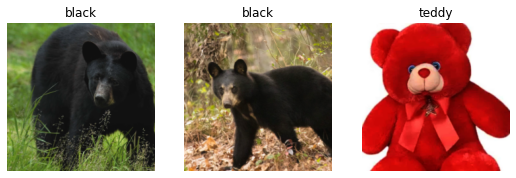

In [56]:
dls.show_batch(nrows=1, ncols=3)

In [57]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.6))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.748103,0.315100,0.942529,00:21
1,0.504031,0.112098,0.959770,00:21
2,0.345879,0.068434,0.977012,00:21
3,0.263723,0.068482,0.977012,00:21


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.024824,0.105198,0.982759,00:21
1,0.024578,0.176488,0.977012,00:23
2,0.021391,0.141891,0.977012,00:22


In [58]:
learn.dls.vocab

['black', 'grizzly', 'teddy']

# Picking Threshold

In [59]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.14189139008522034,0.9655172228813171]

In [60]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.14189139008522034,0.982758641242981]

In [61]:
preds,targs = learn.get_preds()

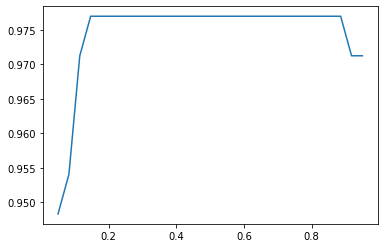

In [62]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

,target,predicted,probabilities,loss
0,black,black;grizzly,"TensorBase([9.9992e-01, 9.9987e-01, 4.5550e-05])",2.9726531505584717
1,teddy,grizzly;teddy,"TensorBase([4.2169e-05, 9.9893e-01, 1.0000e+00])",2.278515100479126
2,grizzly,black;grizzly,"TensorBase([9.8945e-01, 9.1435e-01, 4.5714e-04])",1.5471611022949219
3,black,black;grizzly,"TensorBase([9.9995e-01, 9.6721e-01, 1.7230e-05])",1.1391844749450684
4,teddy,teddy,"TensorBase([1.7590e-04, 1.1705e-01, 1.0000e+00])",0.04155274108052254
5,grizzly,grizzly,"TensorBase([1.0483e-01, 1.0000e+00, 1.5562e-06])",0.036915164440870285
6,teddy,teddy,"TensorBase([6.3045e-06, 9.3848e-02, 1.0000e+00])",0.03285154700279236
7,teddy,teddy,"TensorBase([6.6066e-05, 9.2993e-02, 1.0000e+00])",0.03255714103579521
8,teddy,teddy,"TensorBase([8.2244e-05, 7.2967e-02, 1.0000e+00])",0.025282956659793854


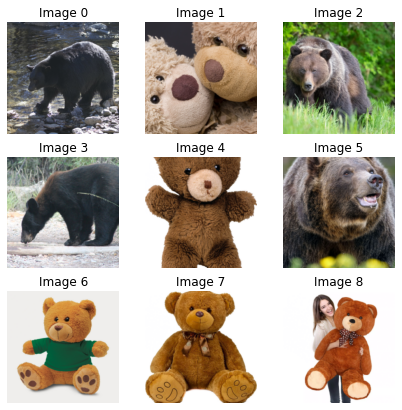

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,7))

In [74]:
"""
path = Path()
learn_inf = load_learner(path/'export.pkl', cpu=True)
"""
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [75]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(460,460))
    pred, idx, probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}'

In [76]:
btn_run.on_click(on_click_classify)

In [77]:
display(VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred]))

# But it's not a Teddy Bear...

A multi-label classifier may be limited to the labels it trained for.